In [1]:
import jaxgym.components as comp
from jaxgym.ray import Ray
from jaxgym.run import run_to_end, calculate_derivatives
from jaxgym.taylor import poly_dict, order_indices, poly_dict_to_sympy_expr

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
%matplotlib widget

import sympy as sp
import os

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_LIMIT_MB"] = "400"

/home/dl277493/JaxTemGym/src/jaxgym/ode.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [2]:
def adjust_phase(wave):
    center_pixel = (wave.shape[0] // 2, wave.shape[1] // 2)
    phase_shift = jnp.angle(wave[center_pixel])
    adjusted_wave = wave * jnp.exp(-1j * phase_shift)
    return adjusted_wave

def remove_high_degree_terms(expr, max_degree):
    filtered_terms = []
    for term in expr.as_ordered_terms():
        powers = [exp for _, exp in term.as_powers_dict().items()]
        total_degree = sum(powers)
        if total_degree < max_degree:
            filtered_terms.append(term)
    return sum(filtered_terms)


def compute_phase(r, wavelength):
    """Compute the phase factor for a given path length array and wavelength."""
    phase = jnp.mod((2 * jnp.pi / wavelength) * r, 2 * jnp.pi) + jnp.pi
    return jnp.exp(1j * phase)

def compute_amplitude_spherical(Z, r, wavelength):
    """Compute the amplitude for a spherical wave."""
    return (1 / (wavelength * 1j)) * (Z / r ** 2)

def get_amplitude_func_xo_xi(S, xo, xi, yo, yi):

    # Compute the second partial derivative of relevant coordinates
    dSdxodxi = sp.diff(S, xo, xi)
    dSdxodyi = sp.diff(S, xo, yi)
    dSdyoxi = sp.diff(S, yo, xi)
    dSdyoyi = sp.diff(S, yo, yi)

    # Place these in a matrix
    jacobian = sp.Matrix([[dSdxodxi, dSdxodyi], [dSdyoxi, dSdyoyi]])

    # Compute the sqrt of the determinant
    det_jacobian = sp.sqrt(jacobian.det())

    return sp.lambdify([xo, xi, yo, yi], det_jacobian, modules='jax')


def get_amplitude_func_ray_jacobian(X, Y, xo, yo, dx, dy):

    # Compute the second partial derivative of relevant coordinates
    dXddx = sp.diff(X, dx)
    dXddy = sp.diff(X, dy)
    dYddx = sp.diff(Y, dy)
    dYddy = sp.diff(Y, dy)

    # Place these in a matrix
    jacobian = sp.Matrix([[dXddx, dXddy], [dYddx, dYddy]])

    # Compute the sqrt of the determinant
    det_jacobian = 1/sp.sqrt(jacobian.det())

    return sp.lambdify([xo, dx, yo, dy], det_jacobian, modules='jax')


def get_path_length_func(S, xo, xi, yo, yi):
    return sp.lambdify([xo, xi, yo, yi], S, modules='jax')

def phase_error_mask_fn(wave1, wave2, threshold=1e-5):
    phase_error = jnp.abs(jnp.angle(wave1) - jnp.angle(wave2))
    phase_error = jnp.where(phase_error > jnp.pi, 2 * jnp.pi - phase_error, phase_error)
    return (phase_error < threshold).astype(jnp.float32)

def amplitude_error_mask_fn(wave1, wave2, threshold=1e-5):
    amplitude_error = jnp.abs(jnp.abs(wave1) - jnp.abs(wave2))
    return (amplitude_error < threshold).astype(jnp.float32)

Ideal Phase and Amplitude of Sphere on Screen from Point Source - Propagation Kernel. 

$$
K_z(x_z - x, y_z - y) \approx \left( \frac{k}{2 \pi i} \right) \frac{n Z}{Z^2 + (x_z - x)^2 + (y_z - y)^2} \times \exp \left[ i k \sqrt{Z^2 + (x_z - x)^2 + (y_z - y)^2} \right].
$$

Setting \( x = 0 \), \( y = 0 \), $n = 1$ and $k = \frac{2\pi}{\lambda}$ we can simplify the kernel to:

$$
K_z(dx, dy) \approx \frac{1}{i \lambda} \cdot \frac{1}{Z(1 + dx^2 + dy^2)} \exp \left[ i \frac{2\pi}{\lambda} Z \sqrt{1 + dx^2 + dy^2} \right]
$$

This is the amplitude and phase of a spherical point source on a screen as a function of distance $Z$, wavelength $\lambda$ and slope $dx$ and $dy$. 

In [3]:
z_init = jnp.array(0.0)
z_image = jnp.array(10.0)

image_array = jnp.zeros((11, 11), jnp.complex128)
image_array = image_array.at[5, 5].set(1.0+0.0j)

wavelength = 1e-3
wavenumber = 2 * jnp.pi / wavelength

PointSourcePlane = comp.ImageGrid(z=z_init, image_array=image_array, image_pixel_size=(1e-8, 1e-8), image_shape=(10, 10), image_rotation=0.0)
Detector = comp.Detector(z=z_image, det_pixel_size=(5e-3, 5e-3), det_shape = (257, 257))
model = [PointSourcePlane, Detector]

ray = Ray(0., 0., 0., 0., 0., z_init, 0.0)
ray_out = run_to_end(ray, model)


In [ ]:
order = 6
derivatives = calculate_derivatives(ray, model, order)

In [5]:
derivatives[0].pathlength

Ray(x=Array(0., dtype=float64, weak_type=True), y=Array(0., dtype=float64, weak_type=True), dx=Array(0., dtype=float64, weak_type=True), dy=Array(0., dtype=float64, weak_type=True), _one=Array(0., dtype=float64, weak_type=True), z=Array(0., dtype=float64, weak_type=True), pathlength=Array(1., dtype=float64, weak_type=True))

In [9]:
selected_vars = ['x', 'y', 'dx', 'dy', 'pathlength']
multi_indices = order_indices(order, n_vars=len(selected_vars))
poly_dicts = poly_dict(derivatives, selected_vars, multi_indices[1:])[0]
x_var, y_var, dx_var, dy_var, opl_var = sp.symbols('x y x_p y_p S')
polynomials = poly_dict_to_sympy_expr(poly_dicts, selected_vars, sym_vars=[x_var, y_var, dx_var, dy_var, opl_var])

In [10]:
detector_coords_xy = Detector.get_coords()

Z = Detector.z - PointSourcePlane.z

detector_coords_image_grid = detector_coords_xy.reshape((2, -1))
det_y = detector_coords_xy[:, 0]
det_x = detector_coords_xy[:, 1]

In [11]:
# Spherical wave
r = jnp.sqrt(detector_coords_xy[:, 0]**2 + detector_coords_xy[:, 1]**2 + Z**2)
phase = compute_phase(r, wavelength)
amplitude = compute_amplitude_spherical(Z, r, wavelength)
spherical_wave = amplitude * phase
spherical_wave = spherical_wave.reshape(*Detector.det_shape)
spherical_wave = adjust_phase(spherical_wave)

# Quadratic wave
xo, xi, yo, yi, z = sp.symbols('x_o, x_i, y_o, y_i z', real=True)
quadratic_path_length = remove_high_degree_terms(polynomials['pathlength'], max_degree=4)
quadratic_path_length_xoxi = quadratic_path_length.subs({dx_var: (xi - xo)/Z, dy_var: (yi - yo)/Z, opl_var: 0.0})
quadratic_amplitude_f_xoxi = get_amplitude_func_xo_xi(quadratic_path_length_xoxi, xo, xi, yo, yi)

quadratic_path_length_f = get_path_length_func(quadratic_path_length_xoxi, xo, xi, yo, yi)

quadratic_r = quadratic_path_length_f(0.0, det_x, 0.0, det_y)
quadratic_phase = compute_phase(quadratic_r, wavelength)
quadratic_amplitude = (1 / (1j * wavelength)) * quadratic_amplitude_f_xoxi(0.0, det_x, 0.0, det_y)
quadratic_wave = quadratic_amplitude * quadratic_phase
quadratic_wave = quadratic_wave.reshape(*Detector.det_shape)
quadratic_wave = adjust_phase(quadratic_wave)

# Fourth Order wave
fourth_order_path_length = remove_high_degree_terms(polynomials['pathlength'], max_degree=6)
fourth_order_path_length = fourth_order_path_length.subs({dx_var: (xi - xo)/Z, dy_var: (yi - yo)/Z, opl_var: 0.0})

fourth_order_amplitude_f = get_amplitude_func_xo_xi(fourth_order_path_length, xo, xi, yo, yi)
fourth_order_path_length_f = get_path_length_func(fourth_order_path_length, xo, xi, yo, yi)

fourth_order_r = fourth_order_path_length_f(0.0, det_x, 0.0, det_y)
fourth_order_phase = compute_phase(fourth_order_r, wavelength)
fourth_order_amplitude = (1 / (1j * wavelength)) * fourth_order_amplitude_f(0.0, det_x, 0.0, det_y)
fourth_order_wave = fourth_order_amplitude * fourth_order_phase
fourth_order_wave = fourth_order_wave.reshape(*Detector.det_shape)
fourth_order_wave = adjust_phase(fourth_order_wave)

# Sixth Order wave
sixth_order_path_length = remove_high_degree_terms(polynomials['pathlength'], max_degree=8)
sixth_order_path_length = sixth_order_path_length.subs({dx_var: (xi - xo)/Z, dy_var: (yi - yo)/Z, opl_var: 0.0})

sixth_order_amplitude_f = get_amplitude_func_xo_xi(sixth_order_path_length, xo, xi, yo, yi)
sixth_order_path_length_f = get_path_length_func(sixth_order_path_length, xo, xi, yo, yi)

sixth_order_r = sixth_order_path_length_f(0.0, det_x, 0.0, det_y)
sixth_order_phase = compute_phase(sixth_order_r, wavelength)
sixth_order_amplitude = (1 / (1j * wavelength)) * sixth_order_amplitude_f(0.0, det_x, 0.0, det_y)
sixth_order_wave = sixth_order_amplitude * sixth_order_phase
sixth_order_wave = sixth_order_wave.reshape(*Detector.det_shape)
sixth_order_wave = adjust_phase(sixth_order_wave)

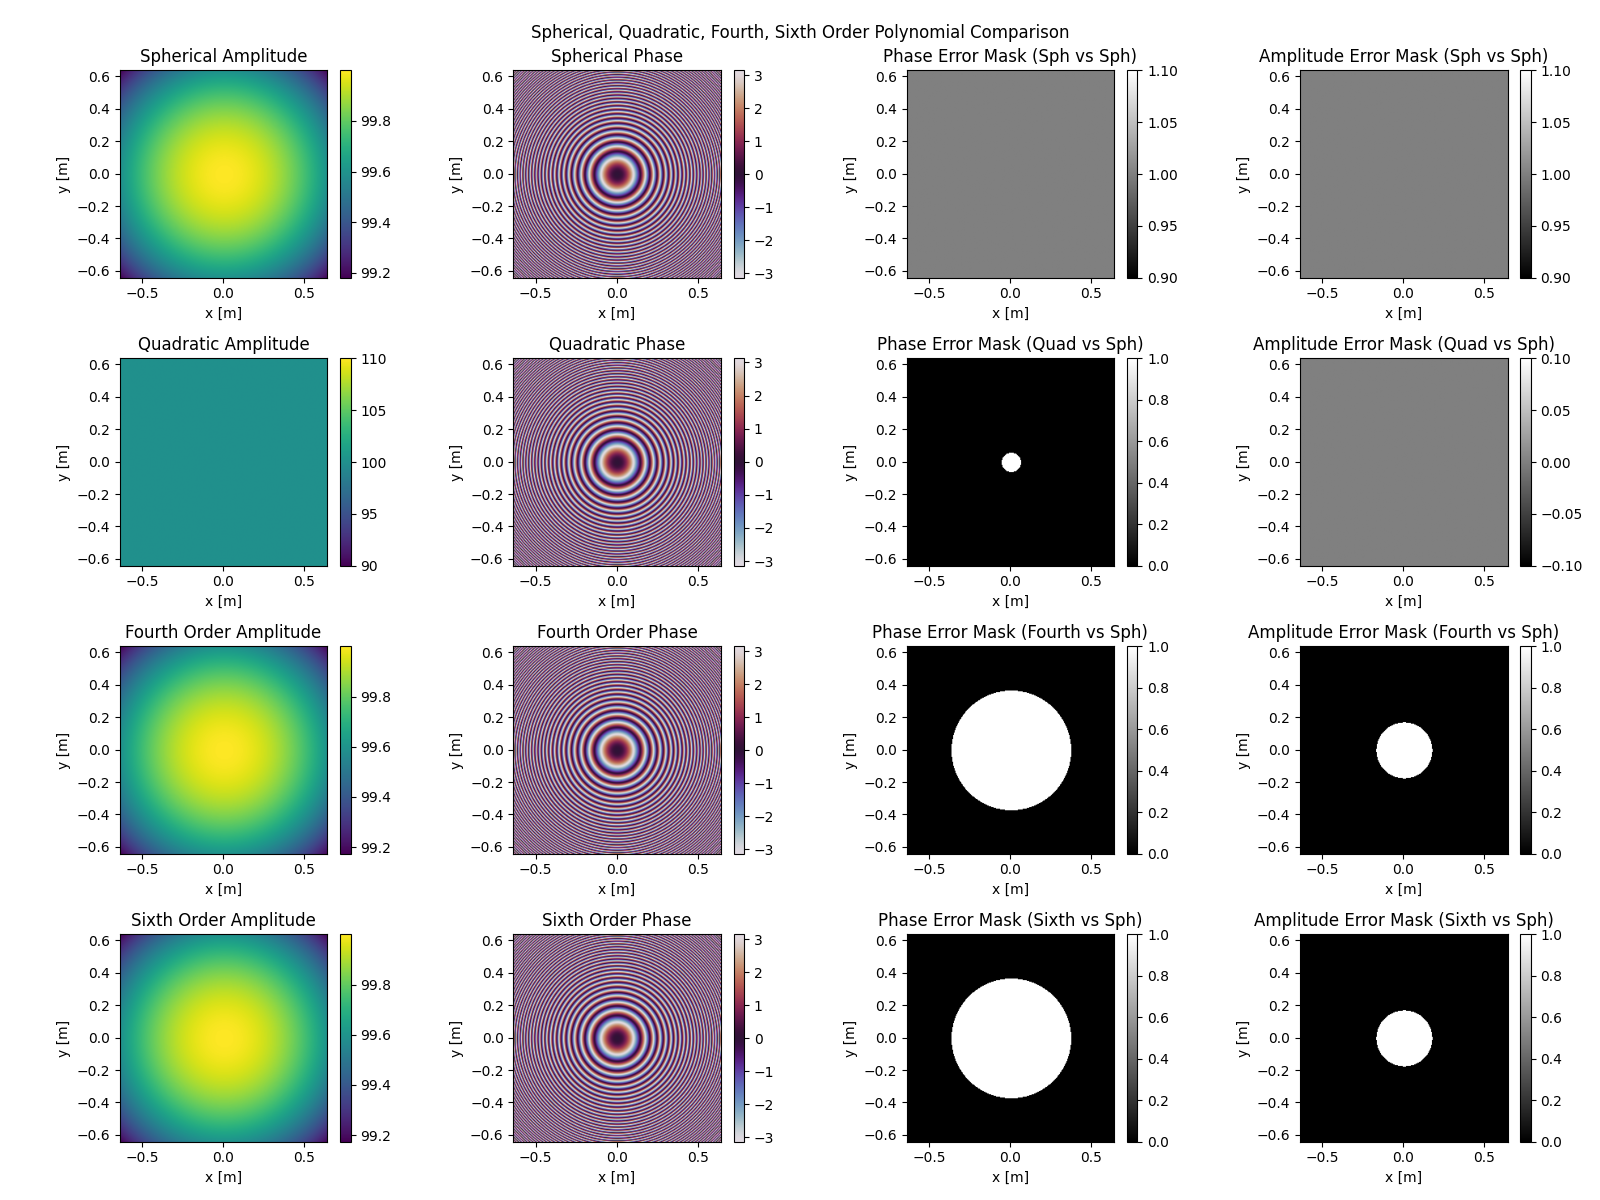

In [12]:
# Spherical vs Spherical (should be all 1s)
phase_error_mask_sph = phase_error_mask_fn(spherical_wave, spherical_wave)
amplitude_error_mask_sph = amplitude_error_mask_fn(spherical_wave, spherical_wave)

# Spherical vs Quadratic
phase_error_mask_quad = phase_error_mask_fn(spherical_wave, quadratic_wave)
amplitude_error_mask_quad = amplitude_error_mask_fn(spherical_wave, quadratic_wave)

# Spherical vs Fourth Order
phase_error_mask_fourth = phase_error_mask_fn(spherical_wave, fourth_order_wave)
amplitude_error_mask_fourth = amplitude_error_mask_fn(spherical_wave, fourth_order_wave)

# Spherical vs Sixth Order
phase_error_mask_sixth = phase_error_mask_fn(spherical_wave, sixth_order_wave)
amplitude_error_mask_sixth = amplitude_error_mask_fn(spherical_wave, sixth_order_wave)

fig, ax = plt.subplots(4, 4, figsize=(16, 12))
plt.suptitle('Spherical, Quadratic, Fourth, Sixth Order Polynomial Comparison')

# Row 1: Spherical
im0 = ax[0, 0].imshow(jnp.abs(spherical_wave), extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()))
ax[0, 0].set_title('Spherical Amplitude')
ax[0, 0].set_xlabel('x [m]')
ax[0, 0].set_ylabel('y [m]')
fig.colorbar(im0, ax=ax[0, 0], fraction=0.046, pad=0.04)

im1 = ax[0, 1].imshow(jnp.angle(spherical_wave), extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()), cmap='twilight')
ax[0, 1].set_title('Spherical Phase')
ax[0, 1].set_xlabel('x [m]')
ax[0, 1].set_ylabel('y [m]')
fig.colorbar(im1, ax=ax[0, 1], fraction=0.046, pad=0.04)

im2 = ax[0, 2].imshow(phase_error_mask_sph, extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()), cmap='gray')
ax[0, 2].set_title('Phase Error Mask (Sph vs Sph)')
ax[0, 2].set_xlabel('x [m]')
ax[0, 2].set_ylabel('y [m]')
fig.colorbar(im2, ax=ax[0, 2], fraction=0.046, pad=0.04)

im3 = ax[0, 3].imshow(amplitude_error_mask_sph, extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()), cmap='gray')
ax[0, 3].set_title('Amplitude Error Mask (Sph vs Sph)')
ax[0, 3].set_xlabel('x [m]')
ax[0, 3].set_ylabel('y [m]')
fig.colorbar(im3, ax=ax[0, 3], fraction=0.046, pad=0.04)

# Row 2: Quadratic
im4 = ax[1, 0].imshow(jnp.abs(quadratic_wave), extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()))
ax[1, 0].set_title('Quadratic Amplitude')
ax[1, 0].set_xlabel('x [m]')
ax[1, 0].set_ylabel('y [m]')
fig.colorbar(im4, ax=ax[1, 0], fraction=0.046, pad=0.04)

im5 = ax[1, 1].imshow(jnp.angle(quadratic_wave), extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()), cmap='twilight')
ax[1, 1].set_title('Quadratic Phase')
ax[1, 1].set_xlabel('x [m]')
ax[1, 1].set_ylabel('y [m]')
fig.colorbar(im5, ax=ax[1, 1], fraction=0.046, pad=0.04)

im6 = ax[1, 2].imshow(phase_error_mask_quad, extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()), cmap='gray')
ax[1, 2].set_title('Phase Error Mask (Quad vs Sph)')
ax[1, 2].set_xlabel('x [m]')
ax[1, 2].set_ylabel('y [m]')
fig.colorbar(im6, ax=ax[1, 2], fraction=0.046, pad=0.04)

im7 = ax[1, 3].imshow(amplitude_error_mask_quad, extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()), cmap='gray')
ax[1, 3].set_title('Amplitude Error Mask (Quad vs Sph)')
ax[1, 3].set_xlabel('x [m]')
ax[1, 3].set_ylabel('y [m]')
fig.colorbar(im7, ax=ax[1, 3], fraction=0.046, pad=0.04)

# Row 3: Fourth Order
im8 = ax[2, 0].imshow(jnp.abs(fourth_order_wave), extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()))
ax[2, 0].set_title('Fourth Order Amplitude')
ax[2, 0].set_xlabel('x [m]')
ax[2, 0].set_ylabel('y [m]')
fig.colorbar(im8, ax=ax[2, 0], fraction=0.046, pad=0.04)

im9 = ax[2, 1].imshow(jnp.angle(fourth_order_wave), extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()), cmap='twilight')
ax[2, 1].set_title('Fourth Order Phase')
ax[2, 1].set_xlabel('x [m]')
ax[2, 1].set_ylabel('y [m]')
fig.colorbar(im9, ax=ax[2, 1], fraction=0.046, pad=0.04)

im10 = ax[2, 2].imshow(phase_error_mask_fourth, extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()), cmap='gray')
ax[2, 2].set_title('Phase Error Mask (Fourth vs Sph)')
ax[2, 2].set_xlabel('x [m]')
ax[2, 2].set_ylabel('y [m]')
fig.colorbar(im10, ax=ax[2, 2], fraction=0.046, pad=0.04)

im11 = ax[2, 3].imshow(amplitude_error_mask_fourth, extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()), cmap='gray')
ax[2, 3].set_title('Amplitude Error Mask (Fourth vs Sph)')
ax[2, 3].set_xlabel('x [m]')
ax[2, 3].set_ylabel('y [m]')
fig.colorbar(im11, ax=ax[2, 3], fraction=0.046, pad=0.04)

# Row 3: sixth Order
im8 = ax[3, 0].imshow(jnp.abs(sixth_order_wave), extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()))
ax[3, 0].set_title('Sixth Order Amplitude')
ax[3, 0].set_xlabel('x [m]')
ax[3, 0].set_ylabel('y [m]')
fig.colorbar(im8, ax=ax[3, 0], fraction=0.046, pad=0.04)

im9 = ax[3, 1].imshow(jnp.angle(sixth_order_wave), extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()), cmap='twilight')
ax[3, 1].set_title('Sixth Order Phase')
ax[3, 1].set_xlabel('x [m]')
ax[3, 1].set_ylabel('y [m]')
fig.colorbar(im9, ax=ax[3, 1], fraction=0.046, pad=0.04)

im10 = ax[3, 2].imshow(phase_error_mask_sixth, extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()), cmap='gray')
ax[3, 2].set_title('Phase Error Mask (Sixth vs Sph)')
ax[3, 2].set_xlabel('x [m]')
ax[3, 2].set_ylabel('y [m]')
fig.colorbar(im10, ax=ax[3, 2], fraction=0.046, pad=0.04)

im11 = ax[3, 3].imshow(amplitude_error_mask_sixth, extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()), cmap='gray')
ax[3, 3].set_title('Amplitude Error Mask (Sixth vs Sph)')
ax[3, 3].set_xlabel('x [m]')
ax[3, 3].set_ylabel('y [m]')
fig.colorbar(im11, ax=ax[3, 3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()